In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp

# Parameters ###################################################################

max_firing_rate = 5         # (per second)
mean_firing_threshold = 0.5 # [Theta] (mV), half of the maximum response of the pop

# Sigmoid slopes (mV^-1) 
r_0 = 0.56
r_1 = 0.56
r_2 = 0.56

# Inverse time constants (s^-1)
a = 100 # excitatory 
ad = 50 # long-range excitatory
b = 50  # inhibitory

# Maximum amplitudes of post-synaptic potential (PSPs) (mV)
A = 3.25 # excitatory
B = 22.0 # inhibitory

# Connectivity constants
C = 135         # Global synaptic connectivity
C1 = C          # Connectivity between Pyramidal and Excitatory
C2 = 0.8 * C    # Connectivity between Excitatory and Pyramidal
C3 = 0.25 * C   # Connectivity between Pyramidal and Inhibitory
C4 = 0.25 * C   # Connectivity between Inhibitory and Pyramidal

# Modified Jansen & Rit Parameters 
# Cholinergic modulation of inhibitory circuits and the segregation/integration balance

# Both as multiples of C
alpha = 0 # excitatory gain, connectivity between long-range pyramidal 
beta = 0  # inhibitory gain, connectibity between inhibitory and excitatory interneuron (short range)

# Structural Connectivity Matrix
num_nodes = 100
SC = np.genfromtxt('SC_in_Schaefer-100.csv', delimiter=',')

In [3]:
# Sigmoid Function - transforms the postynaptic potential (PSP) into an average pulse density 
# v is the average psp, r is the slope of the sigmoid function
# def sigmoid(v, r):
#     return max_firing_rate / (1 + np.exp(r * (mean_firing_threshold - v))) # output is num_nodes x 1 

def sigmoid(v,r):
    return 5 / (1 + np.exp(r * (6 - v)))


# PSPs ###################################################################
# t is average pulse density/spike rate 

# Excitatory PSP
def epsp(t):
    if t < 0:
        return 0
    else:
        return A * a * t * np.exp(-a * t)
    
# Inhibitory PSP
def ipsp(t):
    if t < 0:
        return 0
    else:
        return B * b * t * np.exp(-b * t)

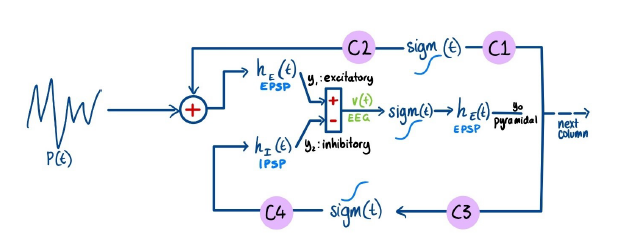

In [4]:
# x3 is a vector of size num_nodes by 1
def calculate_zi(x3):
    return np.dot(SC, x3) # output num_nodes x 1

# System of Equations ########################################################  

norm = np.sqrt(np.sum(SC, axis = 1) * np.sum(SC, axis = 0))
# Expanded Jansen & Rit Model 
def system_of_equations(x):
    x0, y0, x1, y1, x2, y2, x3, y3 = x

    # Noise  - uncorrelated Gaussian-distributed noise with mean 2 and standard deviation 2
    noise = np.random.normal(2,2,num_nodes) # produces a num_nodes x 1 vector 

    dx0dt = y0
    dy0dt = A * a * (sigmoid(C2 * x1 - C4 * x2 + C * alpha * calculate_zi(x3), r_0)) - 2 * a * y0 - a**2 * x0
    dx1dt = y1
    dy1dt = A * a * (noise + sigmoid(C1 * x0 - C * beta * x2, r_1)) - 2 * a * y1 - a**2 * x1
    dx2dt = y2
    dy2dt = B * b * sigmoid(C3 * x0, r_2) - 2 * b * y2 - b**2 * x2
    dx3dt = y3
    dy3dt = A * ad * (sigmoid(C2 * x1 - C4 * x2 + C * alpha * calculate_zi(x3), r_0)) - 2 * ad * y3 - ad**2 * x3
    return [dx0dt, dy0dt, dx1dt, dy1dt, dx2dt, dy2dt, dx3dt, dy3dt] # num_nodes x 8 matrix output 


# Simulation parameters
dt = 0.001  # Step size
euler_length = 50  # Simulation duration for stabilizing (with Euler method)
sim_length = 400 # Simulation time points (to plot)
downsample = 10 # Downsample the simulation results, so less points

# Initial conditions
initial_conditions = np.ones((8, num_nodes)) * 0.5

total_sims = int(euler_length + sim_length/ dt)
total_downsampled_sims = int(total_sims / downsample)

# Array to store results
sol = np.zeros((total_downsampled_sims, 8, num_nodes))
# sol = np.zeros((Ntotal, row, col)) #Matrix to store values
sol[0,:,:] = np.copy(initial_conditions) #First set of initial conditions
sol[0] = initial_conditions
y_temp = np.copy(initial_conditions)

# Run simulation using Euler method
for i in range(1, total_sims):
    y_temp += dt * np.array(system_of_equations(y_temp))
    if i % downsample == 0:
        sol[int(i/downsample)] = np.copy(y_temp)



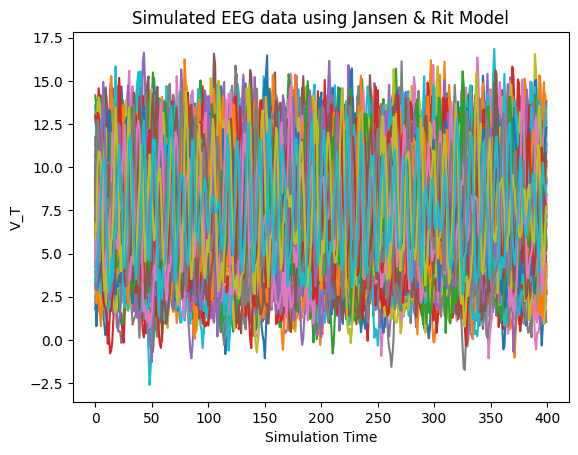

In [5]:
# Plot EEG Results #################################################################
x1 = sol[:, 2]
x2 = sol[:, 4]
x3 = sol[:, 6]

# Calculate V_T for each simulation point
V_T = np.zeros((total_downsampled_sims, num_nodes))

for sim_point in range(total_downsampled_sims):
    # Must produce (100, 1) vector
    V_T[sim_point] = C2 * x1[sim_point] - C4 * x2[sim_point] + C * alpha * calculate_zi(x3[sim_point])

# Downsample the simulation results
V_T_plot = V_T[-sim_length:]

# Plot V_T for each node
for node in range(num_nodes):
    plt.plot(V_T_plot[:, node], label=f'Node {node+1}')

plt.xlabel('Simulation Time')
plt.ylabel('V_T')
plt.title('Simulated EEG data using Jansen & Rit Model')

# Add legend to the right of the plot
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


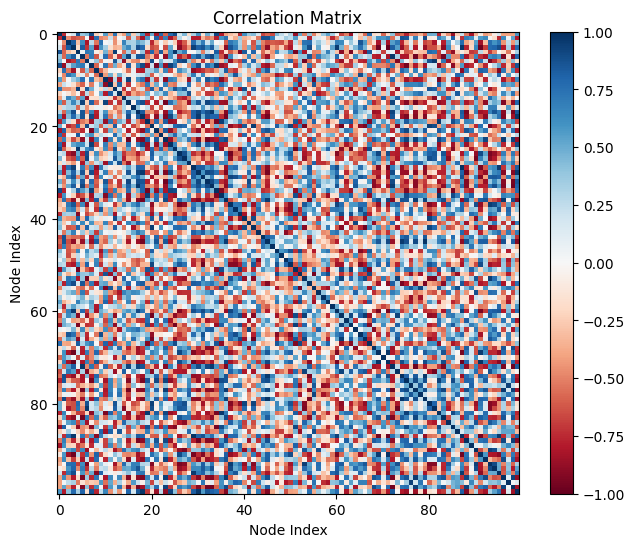

In [6]:
# Balloon-Windkessel Hemodynamic Model #####################################################
# Time Constants
tau_s = 0.65 # Signal decay
tau_f = 0.41 # blood inflow
tau_v = 0.98 # blood volume
tau_q = 0.98 # deoxyhemoglobin content

k = 0.32 # stiffness constant, represents resistance in veins to blood flow
E_0 = 0.4 # resting oxygen extraction rate

# Chosen Constants 
k1 = 2.77
k2 = 0.2
k3 = 0.5

V_0 = 0.03 # fraction of deoxygenated blood in resting state 

# Calculate firing rates, V_T is EEG like response, r_0 is the sigmoid slope
firing_rates = sigmoid(V_T, r_0) # sim_length x num_nodes

scaling = 10000

# ODEs for Balloon Windkessel Model
def balloon_windkessel_ode(state, t):
    # s: vasodilatory response
    # f: blood inflow
    # v: blood volume
    # q: deoxyhemoglobin content
    s, f, v, q = state
    
    # NOTE - multiplying firing rate by a large constant
    ds_dt  = scaling * firing_rates[t] - s / tau_s - (f - 1) / tau_f
    df_dt = s
    dv_dt = (f - v**(1/k)) / tau_v
    dq_dt = ((f * (1 - (1 - E_0)**(1 / f))) / E_0 - (q * v**(1/k)) / v) / tau_q
    
    return [ds_dt, df_dt, dv_dt, dq_dt]

# Initial conditions
initial_conditions = np.array([[0.1, 1, 1, 1]] * num_nodes).T

# Array to store results
BOLD_vars = np.zeros((int(total_downsampled_sims / downsample) + 1 , 4, num_nodes))
BOLD_vars[0] = initial_conditions
BOLD_temp = np.copy(initial_conditions)

# Run simulation using Euler method, NOTE - total_downsampled_sims is the number of timepoints we have firing rates for 
for i in range(total_downsampled_sims):
    BOLD_temp += dt * np.array(balloon_windkessel_ode(BOLD_temp, i))
    if i % downsample == 0:
        # print(int(i/downsample), BOLD_temp[0][25], BOLD_temp[1][25], BOLD_temp[2][25], BOLD_temp[3][25])
        BOLD_vars[int(i/downsample)] = np.copy(BOLD_temp)


BOLD_vars_result = BOLD_vars[-400:]
# Initialize BOLD array - will only take the final sim_length timepoints
BOLD_array = np.zeros((sim_length, num_nodes))

# Generate BOLD array
for t in range(sim_length):
    q = BOLD_vars_result[t, 3, :]
    v = BOLD_vars_result[t, 2, :]
    BOLD_array[t, :] = V_0 * (k1 * (1 - q) + k2 * (1 - (q/v)) + k3 * (1 - v))

# Now have a sim_lengthx100 BOLD array stored in BOLD_array
# Calculate the SC from the BOLD signal

SC_matrix = np.corrcoef(BOLD_array.T)

plt.figure(figsize=(8, 6))
plt.imshow(SC_matrix, cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Correlation Matrix')
plt.xlabel('Node Index')
plt.ylabel('Node Index')
plt.show()

In [7]:
# Calculate goodness of fit for BOLD data ####################################################

# Load the empricical (averaged) FC matrix
observed_fc_matrix = np.load("fc_matrices/averaged_fc_matrix.npy")

# Flatten both and use pearson correlation to calculate goodness of fit
pearson_corr = np.corrcoef(np.ravel(SC_matrix), np.ravel(observed_fc_matrix))[0, 1]

print("Pearson correlation coefficient:", pearson_corr)


Pearson correlation coefficient: 0.08886607873538079


Extracting EDF parameters from c:\Users\stapl\Documents\CDocuments\FinalYearProject\Model\eeg_sample_data\h01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


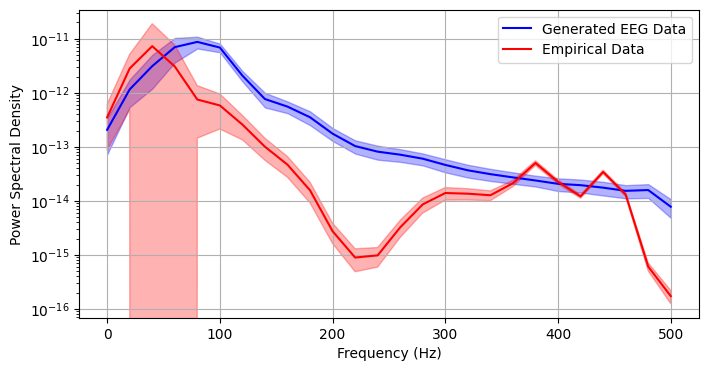

Pearson correlation coefficient between generated and empirical PSDs: 0.4116006836085735


In [77]:
# Calculate goodness of fit for EEG data ####################################################
from scipy.stats import pearsonr
import mne
from scipy.signal import welch

# Load the EDF file
raw_eeg_file = mne.io.read_raw_edf('eeg_sample_data/h01.edf')
# Convert the data to a numpy array
empirical_data = raw_eeg_file.get_data()

# print(V_T_plot.shape) # returns (400, 100) - 400 time points, 100 nodes (brain regions)
# print(empirical_data.shape) # returns (19, 231250) - 19 channels/electrodes with 231250 time points 

# As values in empirical and generated data are very different, scale based on empirical values
# This just makes it look more comparable on the graph
scaling_factor = np.max(empirical_data) / np.max(V_T_plot)
scaled_gen_data = (V_T_plot * scaling_factor).T

sfreq_gen = 1 / dt # Sampling frequency (Hz) (with 0.001, so 1000)
sfreq_emp = 250 # (Hz)
nperseg = 50 # Number of points in output window
noverlap = nperseg // 2  # Overlap between Windows 

# Calculate the Hamming window
window = np.hamming(nperseg)

# Use the maximum sampling frequency for both datasets
sfreq_max = max(sfreq_gen, sfreq_emp)

# Compute the frequency axis using the maximum sampling frequency
frequencies = np.fft.rfftfreq(nperseg, d=1/sfreq_gen)
frequencies1 = np.fft.rfftfreq(nperseg, d=1/sfreq_emp)
print(frequencies.shape)
print(frequencies1.shape)

# Calculate PSD for generated data
psd_gen = np.zeros((scaled_gen_data.shape[0], len(frequencies))) # (100, 26)
for i, channel_data in enumerate(scaled_gen_data): # 0 (400,), 1 (400, ), ... 99 (400, )
    f, power_spectrum = welch(channel_data, fs=(1/dt), window=window, nperseg=nperseg, noverlap=noverlap)
    psd_gen[i, :] = power_spectrum

plt.figure(figsize=(8, 4))
plt.semilogy(frequencies, psd_gen.mean(axis=0), label='Generated EEG Data', color='blue')
# Plot with shaded +- 1 standard deviation above and below
plt.fill_between(frequencies, psd_gen.mean(axis=0) - psd_gen.std(axis=0), psd_gen.mean(axis=0) + psd_gen.std(axis=0), alpha=0.3, color='blue')

# Calculate PSD for empirical data
psd_empirical = np.zeros((empirical_data.shape[0], len(frequencies))) # (19, 26)
for i, channel_data in enumerate(empirical_data): # 0 (231250,), 1 (231250, ), ... 18 (231250, )
    # 250 is taken from data source: https://repod.icm.edu.pl/dataset.xhtml?persistentId=doi:10.18150/repod.0107441
    f, power_spectrum = welch(channel_data, fs=250 , window=window, nperseg=nperseg, noverlap=noverlap)
    psd_empirical[i, :] = power_spectrum

plt.semilogy(frequencies, psd_empirical.mean(axis=0), label='Empirical Data', color='red')
# Plot with shaded +- 1 standard deviation above and below
plt.fill_between(frequencies, psd_empirical.mean(axis=0) - psd_empirical.std(axis=0), psd_empirical.mean(axis=0) + psd_empirical.std(axis=0), alpha=0.3, color='red')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.legend()
plt.grid(True)
plt.show()

# Compute the Pearson correlation between the PSDs - will compare mean at each 26 frequency points
correlation_coefficient, _ = pearsonr(psd_gen.mean(axis=0), psd_empirical.mean(axis=0))

print("Pearson correlation coefficient between generated and empirical PSDs:", correlation_coefficient)